In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
import statistics

#for min-max scaling
from mlxtend.preprocessing import minmax_scaling

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#read the data
diamonds = pd.read_csv('diamonds.csv')

diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [22]:
count_missing = diamonds.isnull().sum()

count_missing[0:10]

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
dtype: int64

None! Say there were missing values. We would have to either drop columns, and then check how much data we dropped. Judging by how much data we dropped, we would choose between dropping columns or imputing the data. Let's check the data types of our data to better see what we're working with.

In [23]:
diamonds.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [24]:
#To get a better idea of what the data is telling us...
diamonds.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Carat - Differences between 25%, 50%, and 75% seem to vary by around .3, not a huge difference. 
Depth - Very litte deviation 
Table - Differences tend to be around 2. 
Price - HUGE differences in prices, especially from 50% to 75%. 
x (length), y (width), z (height) - x and y tend to vary by around 1, while z varies by around .5


# Data Visualization

## Univariate Distributions

Let the 'price' column be our response variable going forward.
Let's look at the univariate distributions of all of our predictors.
Here I'll use the KDE to visualize the data.
KDE plots work by aggregating data into a smooth curve, which is great for interval data, not so great for categorical variables.

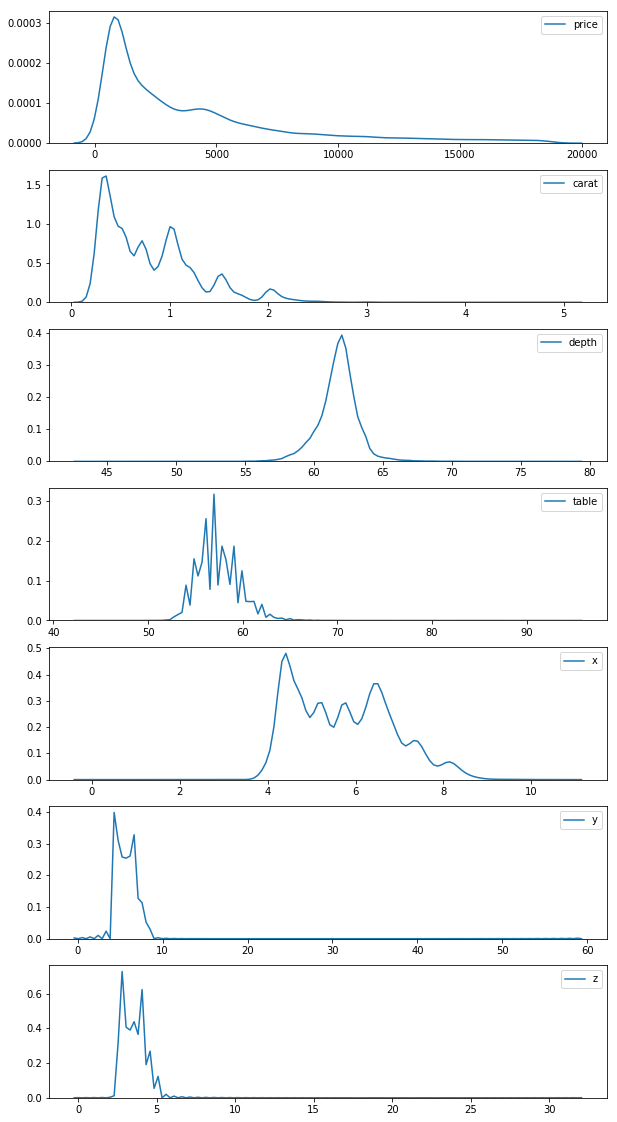

In [9]:
fig, ax = plt.subplots(7, 1, figsize=(10, 20))

sns.kdeplot(diamonds.price, ax=ax[0])
sns.kdeplot(diamonds.carat, ax=ax[1])
sns.kdeplot(diamonds.depth, ax=ax[2])
sns.kdeplot(diamonds.table, ax=ax[3])
sns.kdeplot(diamonds.x, ax=ax[4])
sns.kdeplot(diamonds.y, ax=ax[5])
sns.kdeplot(diamonds.z, ax=ax[6])


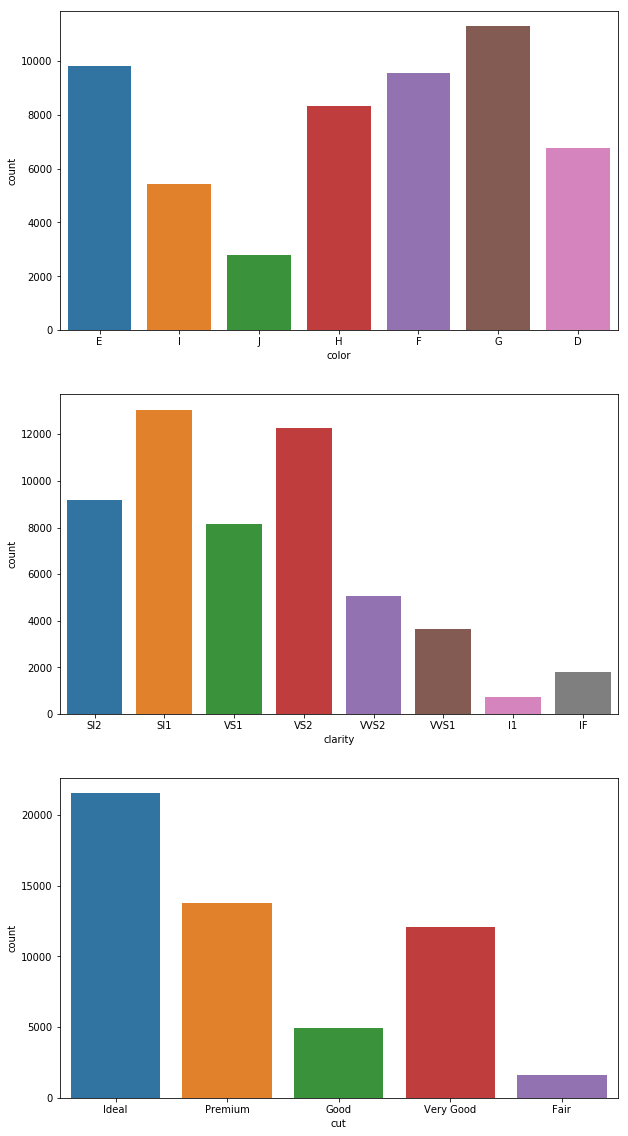

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

sns.countplot(x='color', data=diamonds, ax=ax[0])
sns.countplot(x='clarity', data=diamonds, ax=ax[1])
sns.countplot(x='cut', data=diamonds, ax=ax[2])

Now let's look at the correlation between every pair of values in the dataset.

# Bivariate Distributions
Let's look at the biv. ditr's of the response vairable against all the predictors.

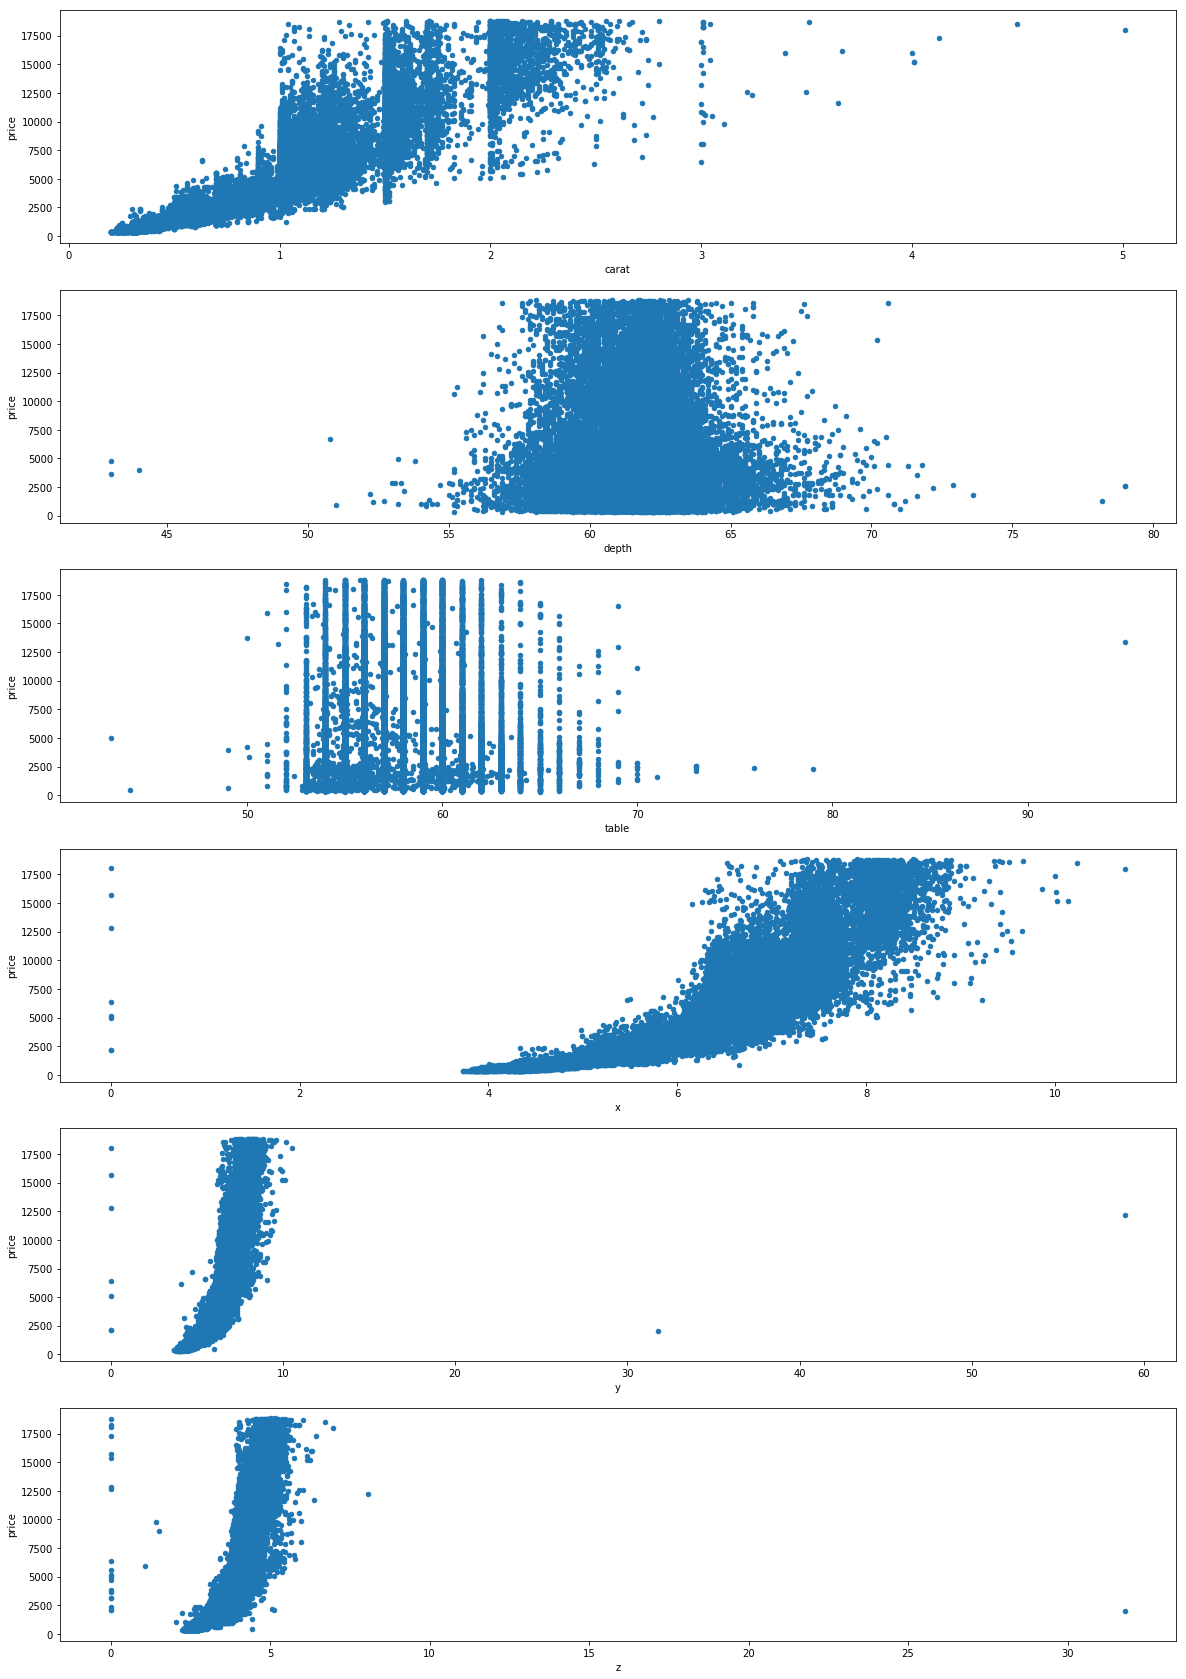

In [29]:
fig, ax = plt.subplots(6, 1, figsize=(20, 30))


diamonds.plot(kind="scatter", x='carat', y='price', ax=ax[0])
diamonds.plot(kind="scatter", x='depth', y='price', ax=ax[1])
diamonds.plot(kind="scatter", x='table', y='price', ax=ax[2])
diamonds.plot(kind="scatter", x='x', y='price', ax=ax[3])
diamonds.plot(kind="scatter", x='y', y='price', ax=ax[4])
diamonds.plot(kind="scatter", x='z', y='price', ax=ax[5])

It appears that depth here is mostly independent from price.

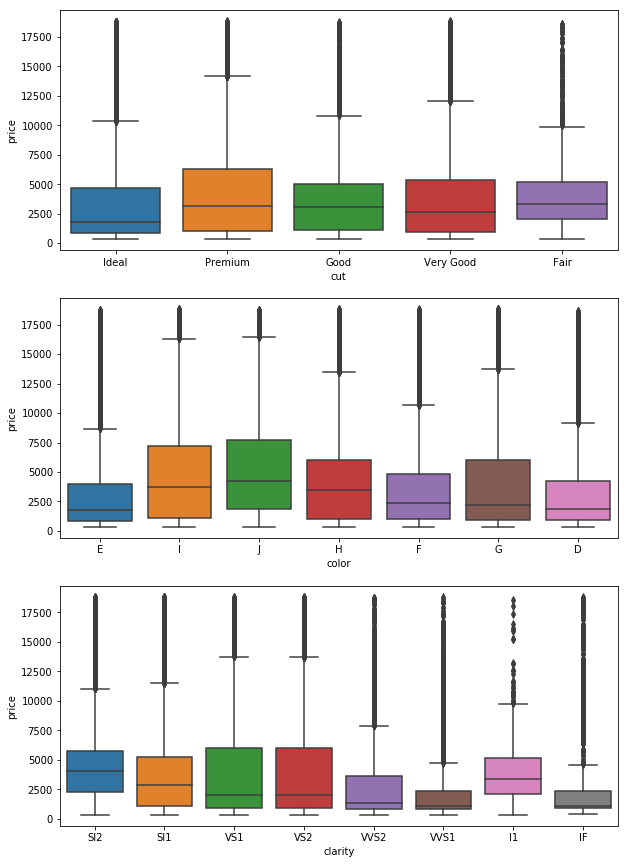

In [30]:
#Categorical Variables - We'll use box plots here.
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.boxplot('cut', 'price', data=diamonds, ax=ax[0])
sns.boxplot('color', 'price', data=diamonds, ax=ax[1])
sns.boxplot('clarity', 'price', data=diamonds, ax=ax[2])

Let's look at depth vs price by predictors cut (using faceting) and color

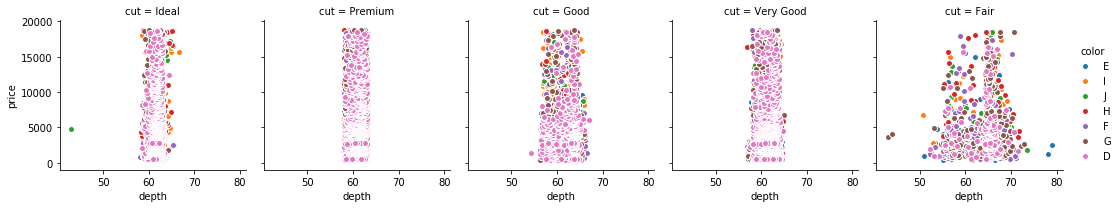

In [31]:
g = sns.FacetGrid(diamonds, col='cut', hue='color')
g = (g.map(plt.scatter, 'depth', 'price', edgecolor='w').add_legend())

Looking at these graphs, we can say that the color of the diamonds are independent from the diamond depth. However, diamond cut is not independent of depth. There's a clear relationship to the depth of the diamonds to the cut. The fair cut has a larger set of diamonds with varying depths, while premium cut diamonds are much more focused on the 60 range of depth.

# Regression 

## Price on Depth
Let's make a linear least squares regression using depth to explain price.

intercept (b0): 5668.590834952138
slope (b1): [-28.18451156]
R squared: 0.0001225747220042761
RMSE:  3996.1870302111547


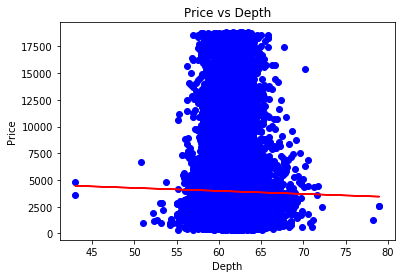

In [19]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

x = diamonds.iloc[:, 5].values.reshape((-1, 1))
y = diamonds.iloc[:, 7].values

#Splitting the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

#Fitting simple linear regression to the training set
model = LinearRegression().fit(x_train, y_train)

#predict the test result
y_pred = model.predict(x_test)

#Coefficients:
print('intercept (b0):', model.intercept_)
print('slope (b1):', model.coef_)

#R^2
r_sq = r2_score(y_test, y_pred)
print('R squared:', r_sq)

#RMSE
rmse = rmse(y_test, y_pred)
print("RMSE: ", rmse)

#Visualization
plt.scatter(x_train, y_train, color = "blue")
plt.plot(x_train, model.predict(x_train), color = "red")
plt.title("Price vs Depth")
plt.xlabel("Depth")
plt.ylabel("Price")
plt.show()

Given from the metrics just caluclated, we can see that price and depth are mostly independent from each other. The visualization, low R_sq and high RMSE help us determine this.

## Price on Carat
Let's create another linear model to predict price based on carat

intercept (b0): -2249.1841412934814
slope (b1): [7745.26084462]
R squared: 0.8506009410929624
RMSE:  1544.7078559024253


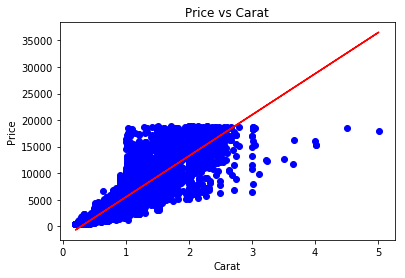

In [21]:
x = diamonds.iloc[:, 1].values.reshape((-1, 1))
y = diamonds.iloc[:, 7].values

#Splitting the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

#Fitting simple linear regression to the training set
model = LinearRegression().fit(x_train, y_train)

#predict the test result
y_pred = model.predict(x_test)

#Coefficients
print('intercept (b0):', model.intercept_)
print('slope (b1):', model.coef_)

#R^2
r_sq = r2_score(y_test, y_pred)
print('R squared:', r_sq)

#RMSE
rmse = mean_squared_error(y_test, y_pred)
print('RMSE: ', math.sqrt(rmse))

#Visualization:
plt.scatter(x_train, y_train, color = "blue")
plt.plot(x_train, model.predict(x_train), color = "red")
plt.title("Price vs Carat")
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

From our graph, high R_sq, and low RMSE scores, we can say there is a correlation between Price and Carat.

## Price on Color
Now let's use color to explain price. However, since the color feature is categorical, there will be more than two coefficients. To explain these coefficients and the price of the diamond in an organized manner, let's use a least squares anova model.

In [4]:
# For statistics
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as sm
import statsmodels.api

model = sm.ols('price ~ C(color)', data=diamonds).fit()

print(model.summary())

anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

r_sq = model.rsquared
rmse = math.sqrt(model.mse_resid)
print("*****")
print("R_sq: ", r_sq)
print("RMSE: ", rmse)
#(RMSE) is the standard deviation of the residuals (prediction errors).
#properties taken from http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     290.2
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:38:00   Log-Likelihood:            -5.2292e+05
No. Observations:               53940   AIC:                         1.046e+06
Df Residuals:                   53933   BIC:                         1.046e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3169.9541     47.707     66.446

Judging from our low R_sq and high RMSE, we can assume that color does not have a huge impact on the price of the diamond.
We can also see more clearly our coefficients. Color has 6 levels, and our chart above shows a value for each color.

## Price on All Features
Now let's use all our features to explain price.

In [5]:
model = sm.ols('price ~ carat + cut + color + clarity + depth + table + x + y + z', data=diamonds).fit()

print(model.summary())

anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)
print("*****")
r_sq = model.rsquared
rmse = math.sqrt(model.mse_resid)
print("R_sq: ", r_sq)
print("RMSE: ", rmse)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:00:35   Log-Likelihood:            -4.5573e+05
No. Observations:               53940   AIC:                         9.115e+05
Df Residuals:                   53916   BIC:                         9.117e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2184.4774    408.197  

Interpreting all of the entries of our b vector:
The intercept shows us that a fair cut, D color, I1 clarity diamond is on average $2,184.48.
(I came to this conclusion by the exclusion of these specific values in our b vector, by looking at the chart above).
To avoid repetitiveness, let's see the price range of one value for each categorical type (cut, color, and clarity). We will compare the rest of our variables as well.

On average, comparing to a fair cut diamond, a diamond of good cut is $579.75 more.
On average, comparing to a D color diamond, a diamond of E color is $209.12 less.
On average, comparing to a I1 clarity diamond, a diamond of IF clarity is $5345.10 more.
On average, increasing carat by 1 will increase price by $11256.98
On average, increasing depth by .01 will decrease the price by $63.81
On average, increasing table by 1 will decrease the price by $26.47
On average, increasing x by 1 will decrase the price by $1008.26
On average, increasing y by 1 will increase the price by $9.61
On average, increasing z by 1 will decrease price by $50.12

Commenting on R_sq, its value is high becuase we are using all available predictors (each of which is relevant to properties of a diamond) to create our model. It is unlikely we overfit this model because there are 50,000 entries in this data set, with features all closely related to the properties of a diamond.